<a href="https://colab.research.google.com/github/RafaelTorresCH/Signal-theory/blob/main/class%20notebooks/NEW_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Paso 1 — Generación del Dataset de Señales Puras

**Objetivo:**  
Crear un conjunto de señales sintéticas (senoidales, cuadradas y rampas) con parámetros aleatorios, para entrenar y validar una red MLP en tareas de clasificación de formas de onda.

---

###  Descripción General

- **Tipos de señales:**  
  1. Senoidal  
  2. Cuadrada  
  3. Rampa (sawtooth lineal)  

- **Parámetros aleatorios:**  
  - Amplitud `A ∈ [0.5, 2.0]`  
  - Frecuencia `f ∈ [2 Hz, 200 Hz]`  
  - Fase `φ ∈ [0, 2π]`  
  - Offset DC `∈ [−0.5, 0.5]`  
  - *Sin ruido añadido*  

- **Duración y muestreo:**  
  - `fs = 1024 Hz`  
  - `N = 1024 muestras` por señal → duración = 1 s  

- **Cantidad total:**  
  - `1500 señales × 3 clases = 4500 señales`

---

###  Proceso de Generación

1. Se define un vector de tiempo `t = np.arange(N)/fs`.  
2. Se crean tres funciones generadoras: `gen_sine()`, `gen_square()`, `gen_ramp()`.  
3. Cada una produce señales con los parámetros aleatorios anteriores.  
4. Se apilan todas las señales en una matriz `X` → forma `(4500, 1024)`  
   y sus etiquetas en `y` → `0: seno`, `1: cuadrada`, `2: rampa`.

---

###  División del Dataset

Se aplica división **estratificada** para conservar el equilibrio de clases:

| Conjunto | Porcentaje | Tamaño aprox. | Descripción |
|-----------|-------------|----------------|--------------|
| Entrenamiento | 60 % | 2700 señales | usado para ajuste del modelo |
| Validación | 20 % | 900 señales | ajuste de hiperparámetros |
| Prueba | 20 % | 900 señales | evaluación final |

---

###  Verificación

Se grafican tres ejemplos por clase del conjunto de entrenamiento para confirmar:
- Formas correctas (seno, cuadrada, rampa)
- Variabilidad en amplitud, frecuencia y offset.

---




Shape X: (4500, 1024) Shape y: (4500,)
Conteo por clase: [1500 1500 1500]

Split 60/20/20
train: 2700 muestras, dist=[900 900 900]
  val:  900 muestras, dist=[300 300 300]
 test:  900 muestras, dist=[300 300 300]


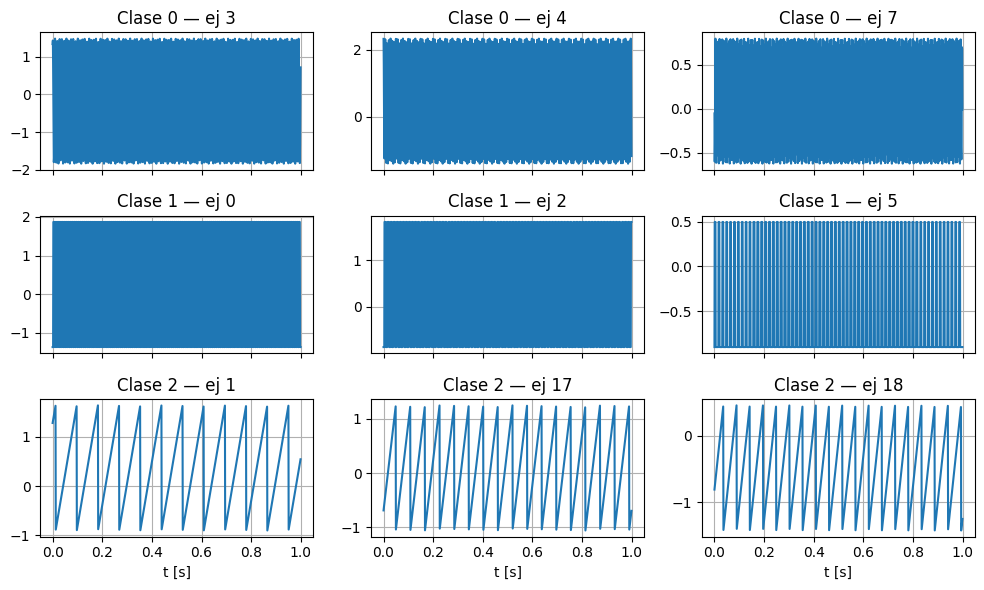


Archivo guardado como dataset_signals_puras_1024.npz


In [5]:
# ==========================================
# Paso 1: Generación de señales puras (sin ruido)
# ==========================================
import numpy as np
from scipy.signal import square, sawtooth
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Parámetros básicos ---
SEED = 42
rng = np.random.default_rng(SEED)

N_PER_CLASS = 1500    # número de señales por tipo
N = 1024              # muestras por señal
fs = 1024             # Hz → duración = 1 s
t = np.arange(N) / fs

AMP_RANGE   = (0.5, 2.0)      # amplitud aleatoria
FREQ_RANGE  = (2.0, 200.0)    # Hz
PHASE_RANGE = (0.0, 2*np.pi)  # radianes
OFFSET_RANGE = (-0.5, 0.5)    # componente DC

# --------------------------
# Generadores de señales
# --------------------------
def rand_uniform(low_high):
    low, high = low_high
    return rng.uniform(low, high)

def gen_sine():
    A = rand_uniform(AMP_RANGE)
    f = rand_uniform(FREQ_RANGE)
    phi = rand_uniform(PHASE_RANGE)
    dc = rand_uniform(OFFSET_RANGE)
    return A*np.sin(2*np.pi*f*t + phi) + dc

def gen_square():
    A = rand_uniform(AMP_RANGE)
    f = rand_uniform(FREQ_RANGE)
    phi = rand_uniform(PHASE_RANGE)
    duty = rng.uniform(0.2, 0.8)
    dc = rand_uniform(OFFSET_RANGE)
    return A*square(2*np.pi*f*t + phi, duty) + dc

def gen_ramp():
    A = rand_uniform(AMP_RANGE)
    f = rng.uniform(1.0, 20.0)      # rampas más lentas
    phi = rand_uniform(PHASE_RANGE)
    dc = rand_uniform(OFFSET_RANGE)
    return A*sawtooth(2*np.pi*f*t + phi, width=1.0) + dc

# --------------------------
# Creación del conjunto total
# --------------------------
gens = [gen_sine, gen_square, gen_ramp]
X_list, y_list = [], []
for cls, g in enumerate(gens):
    for _ in range(N_PER_CLASS):
        X_list.append(g())
        y_list.append(cls)

X = np.stack(X_list).astype(np.float32)
y = np.array(y_list, dtype=np.int64)

print("Shape X:", X.shape, "Shape y:", y.shape)
print("Conteo por clase:", np.bincount(y))

# --------------------------
# División 60/20/20 estratificada
# --------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print("\nSplit 60/20/20")
for name, yy in [("train", y_train), ("val", y_val), ("test", y_test)]:
    counts = np.bincount(yy, minlength=3)
    print(f"{name:>5}: {yy.shape[0]:4d} muestras, dist={counts}")

# --------------------------
# Visualización de ejemplos
# --------------------------
fig, axs = plt.subplots(3, 3, figsize=(10, 6), sharex=True)
for cls in [0, 1, 2]:
    idx = np.where(y_train == cls)[0][:3]
    for i, j in enumerate(idx):
        axs[cls, i].plot(t, X_train[j])
        axs[cls, i].set_title(f"Clase {cls} — ej {j}")
        axs[cls, i].grid(True)
for ax in axs[-1]:
    ax.set_xlabel("t [s]")
plt.tight_layout()
plt.show()

# --------------------------
# Guardado del dataset
# --------------------------
np.savez_compressed(
    "dataset_signals_puras_1024.npz",
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    fs=fs
)
print("\nArchivo guardado como dataset_signals_puras_1024.npz")


## 🧩 Paso 2 — Preprocesamiento de Señales

**Objetivo:**  
Preparar las señales del dataset para que puedan ser usadas eficientemente por la red MLP.

---

###  Tareas principales

1. **Carga del dataset generado en el Paso 1**  
   Se importa el archivo `dataset_signals_puras_1024.npz`.

2. **Centrado de las señales (mean-centering)**  
   - Se resta la media de cada señal:  
     \[
     x_i(t) = x_i(t) - \overline{x_i}
     \]  
   - Esto elimina el componente DC (offset) sin alterar la forma.

3. **Estandarización global (opcional)**  
   - Escalado opcional a media = 0, varianza = 1 (no normalización aún).  
   - Útil para redes con activaciones tipo `ReLU`, `tanh`, o `GELU`.

4. **Verificación visual y estadística**  
   - Se grafica una señal por clase antes y después del centrado.  
   - Se reportan media y desviación estándar para cada conjunto.

5. **Reestructuración de datos para MLP**  
   - Las señales permanecen como vectores de 1024 valores → `(n_samples, 1024)`  
   - Etiquetas en formato entero (0, 1, 2).

---




Dataset cargado correctamente:
Train: (2700, 1024)  Val: (900, 1024)  Test: (900, 1024)
 Train -> mean=+0.0000, std=1.0043
   Val -> mean=-0.0000, std=0.9813
  Test -> mean=-0.0000, std=0.9877


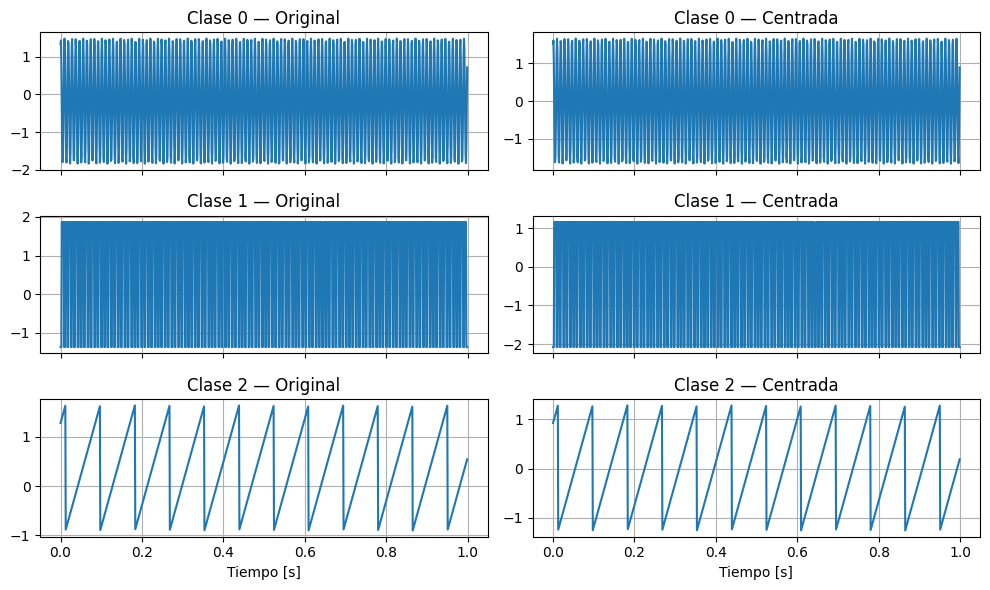


Archivo guardado como dataset_signals_proc_1024.npz


In [6]:
# ==========================================
# Paso 2: Preprocesamiento de señales
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

# --- Cargar dataset del Paso 1 ---
data = np.load("dataset_signals_puras_1024.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]
fs = int(data["fs"])

print("Dataset cargado correctamente:")
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# -------------------------------
# 1️⃣ Centrado por señal
# -------------------------------
X_train_c = X_train - X_train.mean(axis=1, keepdims=True)
X_val_c   = X_val   - X_val.mean(axis=1, keepdims=True)
X_test_c  = X_test  - X_test.mean(axis=1, keepdims=True)

# -------------------------------
# 2️⃣ Verificación de estadísticas
# -------------------------------
def stats(name, X):
    mean_global = np.mean(X)
    std_global = np.std(X)
    print(f"{name:>6} -> mean={mean_global:+.4f}, std={std_global:.4f}")

stats("Train", X_train_c)
stats("Val", X_val_c)
stats("Test", X_test_c)

# -------------------------------
# 3️⃣ Visualización comparativa
# -------------------------------
t = np.arange(X_train.shape[1]) / fs
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)

for cls in [0, 1, 2]:
    idx = np.where(y_train == cls)[0][0]
    axs[cls, 0].plot(t, X_train[idx])
    axs[cls, 0].set_title(f"Clase {cls} — Original")
    axs[cls, 0].grid(True)
    axs[cls, 1].plot(t, X_train_c[idx])
    axs[cls, 1].set_title(f"Clase {cls} — Centrada")
    axs[cls, 1].grid(True)

for ax in axs[-1]:
    ax.set_xlabel("Tiempo [s]")
plt.tight_layout()
plt.show()

# -------------------------------
# 4️⃣ Guardado del resultado
# -------------------------------
np.savez_compressed(
    "dataset_signals_proc_1024.npz",
    X_train=X_train_c, y_train=y_train,
    X_val=X_val_c, y_val=y_val,
    X_test=X_test_c, y_test=y_test,
    fs=fs
)
print("\nArchivo guardado como dataset_signals_proc_1024.npz")


## Paso 3 — Normalización de Señales

**Objetivo:**  
Escalar las señales preprocesadas del Paso 2 a un rango definido para optimizar la convergencia durante el entrenamiento de la red MLP.

---

### Descripción General
Luego del centrado (media ≈ 0), es necesario normalizar la amplitud de cada señal para que todas tengan un rango comparable.  
Esto evita que señales con alta amplitud dominen el aprendizaje.

---

### Tipos de Normalización

#### 1. Normalización Min–Max
Escala cada señal individual al rango $$[0,1]$$:
$$x_{norm}(t)=\frac{x(t)-x_{\min}}{x_{\max}-x_{\min}}$$
o al rango $$[-1,1]$$:
$$x_{norm}(t)=2\cdot\frac{x(t)-x_{\min}}{x_{\max}-x_{\min}}-1$$
donde $$x_{\min}=\min_t x(t),\quad x_{\max}=\max_t x(t)$$ para cada señal de longitud 1024.

---

#### 2. Estandarización Global (opcional)
Escala todo el conjunto a media 0 y desviación estándar 1:
$$x_{std}(t)=\frac{x(t)-\mu}{\sigma}$$
donde $$\mu$$ y $$\sigma$$ son la media y desviación estándar globales del conjunto.  
Para redes MLP con activaciones simétricas (por ejemplo $$\tanh$$ o $$\mathrm{GELU}$$) se recomienda el rango $$[-1,1]$$.

---

### Pasos Aplicados
1. Cargar el dataset centrado del Paso 2.  
2. Aplicar la normalización Min–Max → [-1,1] a cada señal.  
3. Verificar los valores mínimos y máximos (≈ −1 y +1).  
4. Graficar ejemplos normalizados.  
5. Guardar el conjunto resultante para el siguiente paso.

---

### Resultado
Archivo generado:  
`dataset_signals_norm_1024.npz`

Contiene:  
- $$X_{train},X_{val},X_{test}$$ ya normalizados  
- $$y_{train},y_{val},y_{test}$$  
- $$f_s$$ (frecuencia de muestreo)

El resultado esperado es un dataset con todas las señales en el rango $$[-1,1]$$, listo para la construcción y entrenamiento de la MLP en el Paso 4.


Dataset cargado:
Train: (2700, 1024)  Val: (900, 1024)  Test: (900, 1024)
 Train -> min=-1.000, max=+1.000, mean=-0.000
   Val -> min=-1.000, max=+1.000, mean=-0.002
  Test -> min=-1.000, max=+1.000, mean=-0.010


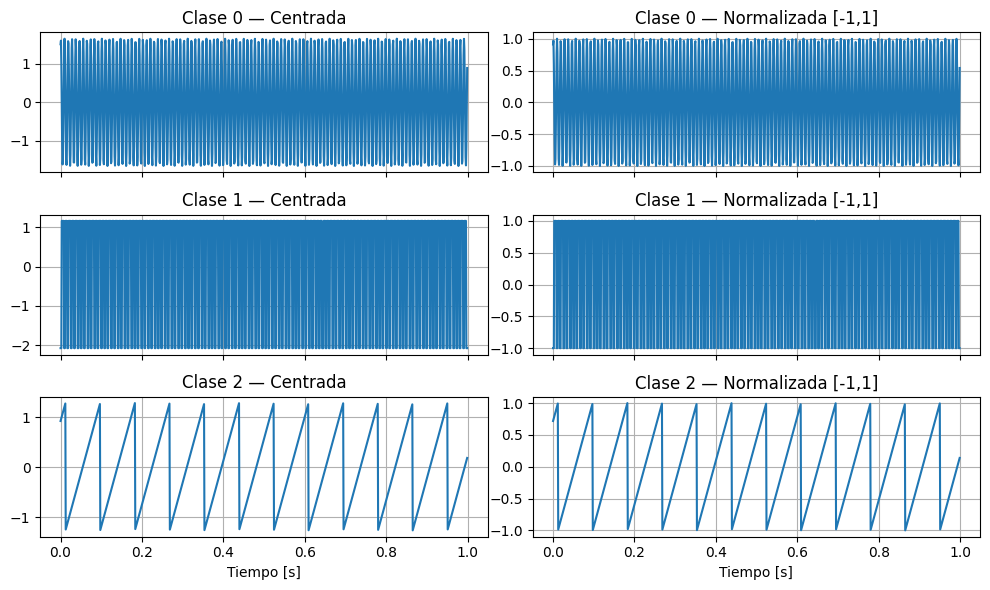


Archivo guardado como dataset_signals_norm_1024.npz


In [7]:
# ==========================================
# Paso 3: Normalización de señales
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

# --- Cargar dataset preprocesado (Paso 2) ---
data = np.load("dataset_signals_proc_1024.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]
fs = int(data["fs"])

print("Dataset cargado:")
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# -------------------------------
# 1️⃣ Normalización Min-Max → [-1, 1]
# -------------------------------
def minmax_norm(X):
    X_min = X.min(axis=1, keepdims=True)
    X_max = X.max(axis=1, keepdims=True)
    return 2 * (X - X_min) / (X_max - X_min + 1e-12) - 1

X_train_n = minmax_norm(X_train)
X_val_n   = minmax_norm(X_val)
X_test_n  = minmax_norm(X_test)

# -------------------------------
# 2️⃣ Verificación de rangos
# -------------------------------
for name, X in [("Train", X_train_n), ("Val", X_val_n), ("Test", X_test_n)]:
    print(f"{name:>6} -> min={X.min():+.3f}, max={X.max():+.3f}, mean={X.mean():+.3f}")

# -------------------------------
# 3️⃣ Visualización comparativa
# -------------------------------
t = np.arange(X_train.shape[1]) / fs
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)

for cls in [0, 1, 2]:
    idx = np.where(y_train == cls)[0][0]
    axs[cls, 0].plot(t, X_train[idx])
    axs[cls, 0].set_title(f"Clase {cls} — Centrada")
    axs[cls, 0].grid(True)
    axs[cls, 1].plot(t, X_train_n[idx])
    axs[cls, 1].set_title(f"Clase {cls} — Normalizada [-1,1]")
    axs[cls, 1].grid(True)

for ax in axs[-1]:
    ax.set_xlabel("Tiempo [s]")
plt.tight_layout()
plt.show()

# -------------------------------
# 4️⃣ Guardar dataset normalizado
# -------------------------------
np.savez_compressed(
    "dataset_signals_norm_1024.npz",
    X_train=X_train_n, y_train=y_train,
    X_val=X_val_n, y_val=y_val,
    X_test=X_test_n, y_test=y_test,
    fs=fs
)
print("\nArchivo guardado como dataset_signals_norm_1024.npz")


## Paso 4 — Extracción de PSD (Welch) para usarla como entrada del modelo

**Objetivo:**  
Transformar cada señal temporal en su densidad espectral de potencia (PSD) y construir un dataset de espectros para entrenar la MLP.

---

### Fundamento

La PSD caracteriza la distribución de potencia por frecuencia.  
Con el método de Welch, se divide la señal en tramos solapados, se aplica ventana y se promedia el espectro:

$$
S_x(f)=\frac{1}{K}\sum_{k=1}^{K}\frac{1}{U}\,\bigl|\mathcal{F}\{w(t)\,x_k(t)\}\bigr|^2
$$

donde  
$$x_k(t)$$ es el segmento $$k$$,  
$$w(t)$$ es la ventana (Hann),  
$$U=\frac{1}{N}\sum_{n=0}^{N-1}w^2[n]$$ es el factor de normalización de la ventana.

Para mejorar la condición numérica se usa escala logarítmica:

$$
\mathrm{PSD}_{\mathrm{dB}}(f)=10\log_{10}\bigl(S_x(f)+\varepsilon\bigr),\quad \varepsilon>0
$$

---

### Decisiones de diseño

- Señales de entrada: las **centradas** del Paso 2 (no usar Min–Max antes de PSD para no distorsionar potencia).  
- Welch:
  - ventana Hann,  
  - $$n_{\mathrm{perseg}}_


Cargado: (2700, 1024) (900, 1024) (900, 1024) fs= 1024.0
F.shape: (129,) Δf≈ 4.0 Hz; Fmax≈ 512.0 Hz
S_train_dB: (2700, 129) rango dB: [ -120.0 , -8.695116 ]
S_train_dBnorm: (2700, 129) rango ~[-1,1]: [ -1.0 , 1.0 ]


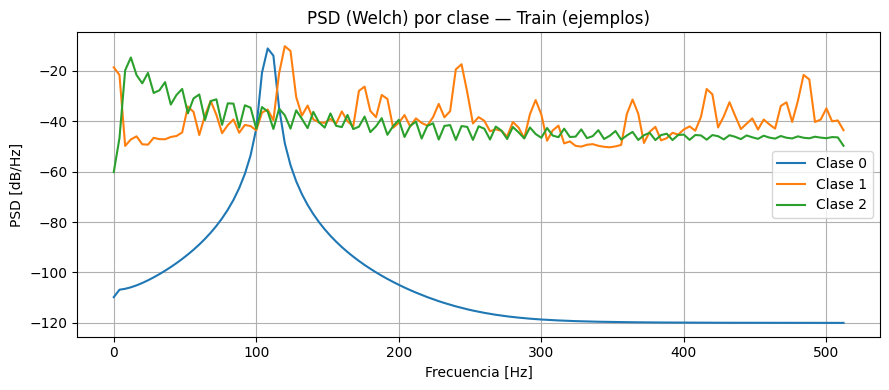


Archivo guardado: dataset_psd_welch_1024.npz


In [9]:
# ==========================================
# Paso 4: Cálculo de la PSD y dataset espectral
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window

# --- Cargar señales normalizadas del Paso 3 ---
D = np.load("dataset_signals_norm_1024.npz")
X_train, y_train = D["X_train"], D["y_train"]
X_val,   y_val   = D["X_val"],   D["y_val"]
X_test,  y_test  = D["X_test"],  D["y_test"]
fs = float(D["fs"])

print("Cargado:", X_train.shape, X_val.shape, X_test.shape, "fs=", fs)

# --- Parámetros de Welch ---
L = 256                # nperseg
noverlap = 128
window = get_window("hann", L)
scaling = "density"    # PSD verdadera (W/Hz) si unidades aplicaran

# --- Funciones auxiliares ---
def psd_welch_matrix(X, fs, nperseg, noverlap, window, scaling="density"):
    """
    Aplica Welch a cada fila de X (cada señal) y apila resultados.
    Retorna matriz S_lin de tamaño (num_signals, K) y vector de frecuencias f.
    """
    S_list = []
    f = None
    for x in X:
        f_i, Pxx = welch(
            x, fs=fs, window=window, nperseg=nperseg,
            noverlap=noverlap, detrend=False, return_onesided=True,
            scaling=scaling
        )
        if f is None:
            f = f_i
        S_list.append(Pxx)
    return f, np.vstack(S_list)

def to_dB(S_lin, eps=1e-12):
    return 10.0 * np.log10(S_lin + eps)

def minmax_neg1_pos1(M, axis=1, eps=1e-12):
    """
    Normaliza cada fila de M a [-1,1] vía min-max.
    """
    mmin = M.min(axis=axis, keepdims=True)
    mmax = M.max(axis=axis, keepdims=True)
    return 2.0 * (M - mmin) / (mmax - mmin + eps) - 1.0

# --- Cálculo de PSDs ---
F, S_train_lin = psd_welch_matrix(X_train, fs, L, noverlap, window, scaling=scaling)
_, S_val_lin   = psd_welch_matrix(X_val,   fs, L, noverlap, window, scaling=scaling)
_, S_test_lin  = psd_welch_matrix(X_test,  fs, L, noverlap, window, scaling=scaling)

S_train_dB = to_dB(S_train_lin)
S_val_dB   = to_dB(S_val_lin)
S_test_dB  = to_dB(S_test_lin)

# --- Normalización por señal (dB) a [-1,1] para MLP ---
S_train_dBnorm = minmax_neg1_pos1(S_train_dB)
S_val_dBnorm   = minmax_neg1_pos1(S_val_dB)
S_test_dBnorm  = minmax_neg1_pos1(S_test_dB)

# --- Verificación básica ---
print("F.shape:", F.shape, "Δf≈", F[1]-F[0], "Hz; Fmax≈", F[-1], "Hz")
print("S_train_dB:", S_train_dB.shape, "rango dB: [", S_train_dB.min(), ",", S_train_dB.max(), "]")
print("S_train_dBnorm:", S_train_dBnorm.shape, "rango ~[-1,1]: [", S_train_dBnorm.min(), ",", S_train_dBnorm.max(), "]")

# --- Visualización de ejemplo: 1 señal por clase (dB) ---
def plot_example_per_class(S_dB, F, y, title):
    plt.figure(figsize=(9,4))
    for c in [0,1,2]:
        idx = np.where(y==c)[0][0]
        plt.plot(F, S_dB[idx], label=f"Clase {c}")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("PSD [dB/Hz]")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_example_per_class(S_train_dB, F, y_train, "PSD (Welch) por clase — Train (ejemplos)")

# --- Guardado del dataset espectral ---
np.savez_compressed(
    "dataset_psd_welch_1024.npz",
    F=F,
    S_train_lin=S_train_lin, S_val_lin=S_val_lin, S_test_lin=S_test_lin,
    S_train_dB=S_train_dB, S_val_dB=S_val_dB, S_test_dB=S_test_dB,
    S_train_dBnorm=S_train_dBnorm, S_val_dBnorm=S_val_dBnorm, S_test_dBnorm=S_test_dBnorm,
    y_train=y_train, y_val=y_val, y_test=y_test,
    fs=fs, L=L, noverlap=noverlap
)
print("\nArchivo guardado: dataset_psd_welch_1024.npz")


In [10]:
# ==========================================
# Paso 5: Tuning y entrenamiento MLP con PSD
# ==========================================
!pip -q install keras-tuner --upgrade

import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

# --- Cargar dataset espectral del Paso 4 ---
D = np.load("dataset_psd_welch_1024.npz")
S_tr  = D["S_train_dBnorm"].astype(np.float32)
S_va  = D["S_val_dBnorm"].astype(np.float32)
S_te  = D["S_test_dBnorm"].astype(np.float32)
y_tr  = D["y_train"].astype(np.int64)
y_va  = D["y_val"].astype(np.int64)
y_te  = D["y_test"].astype(np.int64)
F     = D["F"]
fs    = float(D["fs"])

print("Shapes:", S_tr.shape, S_va.shape, S_te.shape, "K =", S_tr.shape[1])

num_classes = int(len(np.unique(y_tr)))
input_dim   = int(S_tr.shape[1])

# --- Constructor del modelo para Keras Tuner ---
def build_model(hp: kt.HyperParameters) -> tf.keras.Model:
    n1 = hp.Choice("units_1", [128, 256, 512])
    n2 = hp.Choice("units_2", [64, 128, 256])
    act = hp.Choice("activation", ["relu", "gelu"])
    dr  = hp.Choice("dropout", [0.0, 0.1, 0.2, 0.3])
    lr  = hp.Choice("lr", [1e-3, 5e-4, 1e-4])

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(n1, activation=act),
        Dropout(dr),
        Dense(n2, activation=act),
        Dense(num_classes, activation="softmax"),
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- Tuner (RandomSearch) ---
project_name = "tuner_results"
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=20,              # puedes subirlo si quieres explorar más
    executions_per_trial=1,
    overwrite=True,
    directory=".",
    project_name=project_name
)

batch_hp = [32, 64, 128]

# --- Callbacks de tuning ---
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# --- Búsqueda de hiperparámetros ---
tuner.search(
    S_tr, y_tr,
    validation_data=(S_va, y_va),
    epochs=100,
    batch_size=np.random.choice(batch_hp),
    callbacks=[es],
    verbose=1
)

# --- Mejor conjunto y mejor modelo ---
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nMejores hiperparámetros:")
for k in best_hp.values.keys():
    print(f" - {k}: {best_hp.get(k)}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# --- Entrenamiento final del mejor modelo (con early stopping y checkpoint) ---
ckpt = ModelCheckpoint(
    "mlp_psd_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history = best_model.fit(
    S_tr, y_tr,
    validation_data=(S_va, y_va),
    epochs=150,
    batch_size=best_hp.get("batch_size") if "batch_size" in best_hp.values.keys() else 64,
    callbacks=[EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1), ckpt],
    verbose=1
)

# --- Evaluación en test ---
test_loss, test_acc = best_model.evaluate(S_te, y_te, verbose=0)
print(f"\nRendimiento en test -> loss: {test_loss:.4f}, accuracy: {test_acc*100:.2f}%")

# --- Gráficas de entrenamiento ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Pérdida")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Exactitud")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Guardar arquitectura en JSON ---
with open("mlp_psd_best.json", "w") as f:
    f.write(best_model.to_json())

print("\nArtefactos guardados:")
print(" - mlp_psd_best.h5 (mejores pesos)")
print(" - mlp_psd_best.json (arquitectura)")
print(" - carpeta tuner_results/ (registros del tuner)")


Trial 19 Complete [00h 00m 44s]
val_accuracy: 0.9866666793823242

Best val_accuracy So Far: 0.9933333396911621
Total elapsed time: 00h 06m 58s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
256               |256               |units_1
128               |128               |units_2
gelu              |gelu              |activation
0.1               |0                 |dropout
0.001             |0.0005            |lr

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7846 - loss: 0.5520 - val_accuracy: 0.9567 - val_loss: 0.1817
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9593 - loss: 0.1371 - val_accuracy: 0.9656 - val_loss: 0.1282
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9627 - loss: 0.1141 - val_accuracy: 0.9711 - val_loss: 0.0871
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9701 - loss: 0.0917 - val_accuracy: 0.9733 - val_loss: 0.0756
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 